# Convert data to MIDI (Discrete and Continuous)

Example notebook to map discrete data (form a csv) into musical notes and to map continuous data (from an image or csv) into smoothly varrying control changes. Place your own csv file and/or image in '/data/' and customize the script. 

### Install required libraries (can skip if they're already installed)

In [1]:
import sys
#install with pip 
!{sys.executable} -m pip install --quiet "pandas" "matplotlib" "audiolazy" "midiutil" "numpy" "Pillow"

#or use this if you installed python with anaconda
#conda install --yes --prefix {sys.prefix} pandas matplotlib audiolazy midiutil numpy Pillow

### import utility functions needed for this notebook

In [3]:
from bcfunctions import *

# map_value(value, min_value, max_value, min_result, max_result, power=1) 

# get_scale_notes(start_note, octaves, scale)

# save_midi(events, out_filename, bpm=60)

# save_midi_cc(events, events_cc, out_filename, bpm=60)

# Discrete data
Map individual data points to musical notes.

### 1) Load data (csv file)

In [4]:
import pandas as pd   

data_filename = 'lunarCraterAges'  #name of csv data file, place in /data

df = pd.read_csv('./data/' + data_filename + '.csv')  #load data as a pandas dataframe
#df = df[(df['diameter'] >= 20)] #filter data if you like (for example, only craters larger than 20km)

df = df.sort_values(by=['longitude']) #sort data (optional, doesn't affect the sonification)

df.head() #take a look at first 5 rows
#df.tail() #take a look at last 5 rows

,names,longitude,latitude,diameter,age
100,Aratus,4.52681,23.57279,10.6,421
58,Egede A,10.50508,51.56250,13.0,84
25,Dionysius,17.29907,2.75990,18.7,492
95,Alfraganus C,18.08978,-6.12891,10.7,433
49,Nicolai A,23.58830,-42.46670,13.7,669


### 2) Plot data

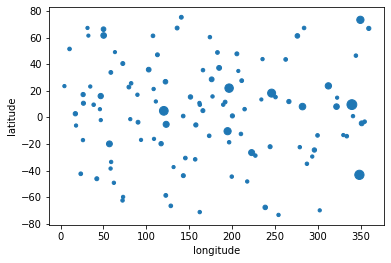

In [5]:
import matplotlib.pylab as plt  #import library for plotting, https://pypi.org/project/matplotlib/

longitudes = df['longitude'].values    #this is a numpy array (not a list), you can do mathematical operations directly on the object
latitudes = df['latitude'].values    
diameters = df['diameter'].values 

plt.scatter(longitudes, latitudes, s=diameters)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()


### 3) Map longitude to time

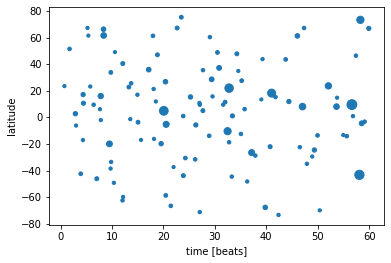

In [6]:
duration = 60 #set duration in seconds 

t_data =  map_value(longitudes, 0, 360, 0., duration) 

##to quantize the data to 16th notes (quarter of a beat), for example:
#t_data = np.round(t_data*4)/4

plt.scatter(t_data, latitudes, s=diameters)
plt.xlabel('time [beats]')
plt.ylabel('latitude')
plt.show()

### 4) Map crater latitude to musical pitch, map diameter to note velocity

In [7]:
#choose note set 
note_names = get_scale_notes('C3', 3, 'lydian')
print(note_names)

note_numbers = np.array([str2midi(n) for n in note_names]) #make it an array so we can use do indexing on it with another array

print(note_numbers)


['C3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F#4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F#5', 'G5', 'A5', 'B5', 'C6']
[48 50 52 54 55 57 59 60 62 64 66 67 69 71 72 74 76 78 79 81 83 84]


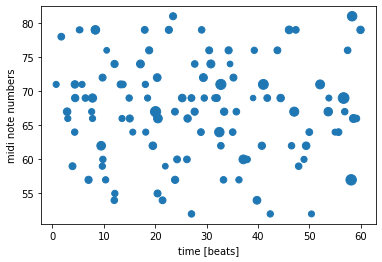

In [8]:

#map latitudes to midi note numbers 
midi_data = note_numbers[map_value(latitudes, -90, 90, 0, len(note_numbers)-1)] #map_value will return array of indices, corresponding to notes in note_numbers


#map diameters to note velocity
vel_min,vel_max = 30,115   #set minimum and maximum note velocity
vel_data = map_value(diameters, min(diameters), max(diameters), vel_min, vel_max, power=0.5)

plt.scatter(t_data, midi_data, s=vel_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

### 5) Save data as MIDI file
We'll organize the MIDI events as a list of dictionaries. Then we can feed this list to a function to save as a MIDI file. The save_midi function could be generalized to write multi-track and multi-channel midi files.

In [9]:

events = []
for i in range(len(t_data)):
    event = {}
    
    event['t'] = t_data[i]
    event['midi'] = midi_data[i]
    event['vel'] = vel_data[i]
    
    event['dur'] = 2 #set duration of each note to 2 beats 
    events.append(event)
     

In [10]:
midi_filename = 'craters'
    
save_midi(events,'./midi/' + midi_filename, bpm=60)

saved ./midi/craters.mid


# Continuous DATA

Map continuous data to smoothly varying control changes.


### 1) Load data

We'll use image data, but you can load data from a csv file instead.

Image dimensions: 1024 512


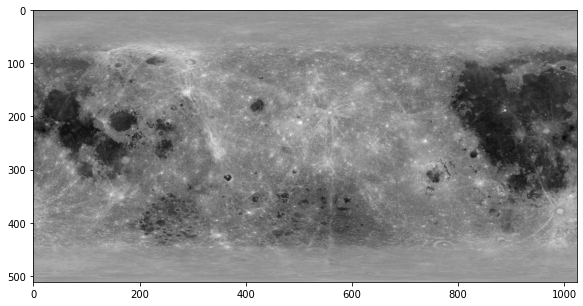

In [10]:
from PIL import Image 
import numpy as np
import matplotlib.pylab as plt  
from bcfunctions import *

image_filename = 'moon_surface'
im = Image.open('./data/' + image_filename + '.jpg' ) #can use jpg or png
width, height = im.size
print('Image dimensions:',width, height)

im_grey = im.convert('L') #convert to greyscale

im_grey = np.roll(im_grey, int(width/2)) #shift so that longitude=0 is at x=0 (left side), so that it matches the crater data

plt.figure( figsize=(10,5) )
plt.imshow(im_grey, cmap='gray')
# plt.scatter(map_value(longitudes, 0, 360, 0, width), map_value(latitudes, -90, 90, height, 0), s=diameters, alpha=0.5)


### 2) Plot the average brightness of each column

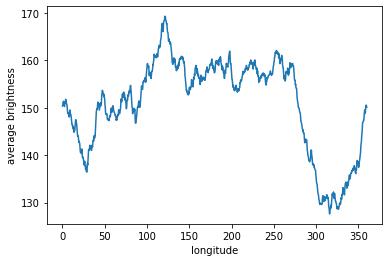

In [2]:

avg_brightness = np.mean(im_grey, axis=0) #average pixel value of each column

im_longitudes = np.linspace(0, 360, len(avg_brightness)) #array of each column's longitude (just for plotting)

plt.plot(im_longitudes, avg_brightness)
plt.xlabel('longitude')
plt.ylabel('average brightness')
plt.show()

### 3) Map average brightness to a control change parameter
We'll use a limited range for the CC value, centered around the midpoint, 63. Full range is 0,127.

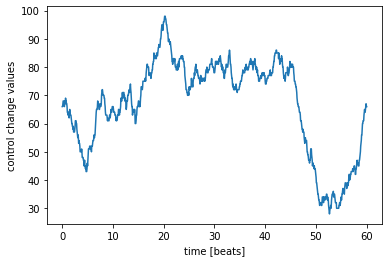

In [3]:
duration = 60 #set duration in seconds

cc_min,cc_max = 63 - 35, 63 + 35 #limited CC range, centered around the midpoint 63

brightness_cc = map_value(avg_brightness, min(avg_brightness), max(avg_brightness), cc_min, cc_max )

time_cc_im = np.linspace(0, duration, len(brightness_cc)) #one time sample for each column

plt.plot(time_cc_im, brightness_cc)
plt.xlabel('time [beats]')
plt.ylabel('control change values')
plt.show()

### 4) Save CC events with a single long note 
We'll assign the CC events to control the pitch bend of a synth in a DAW.

In [8]:
events = [{
    't': 0, 
    'midi': 60, 
    'vel': 100, 
    'dur': duration
    }] #make single long note

controller_number = 1 #modulation (this can be anything)

events_cc=[]
for i in range(len(time_cc_im)):
    events_cc.append({
        't':time_cc_im[i], 
        'controller_number':controller_number, 
        'parameter':brightness_cc[i]
    })
    


midi_cc_filename = 'brightness_note'

save_midi_cc(events, events_cc, './midi/' + midi_cc_filename, bpm=60)

saved ./midi/brightness_note_cc.mid


### 5) Save CC events with a long chord 
We'll assign the CC events to control the cutoff frequency of a filter in a DAW.

In [9]:

chord_note_names=['C2','C3','G3','E4']  # C major chord
chord_note_numbers = [str2midi(c) for c in chord_note_names]

events=[]
for i in range(len(chord_note_numbers)):
    events.append({
        't': 0, 
        'midi': chord_note_numbers[i], 
        'vel': 100, 
        'dur': duration
    })


controller_number = 74 # cutoff=74 (this can be anything)

events_cc=[]
for i in range(len(time_cc_im)):
    events_cc.append({
        't':time_cc_im[i], 
        'controller_number':controller_number, 
        'parameter':brightness_cc[i]
    })

midi_cc_filename = 'brightness_chord'

save_midi_cc(events, events_cc, './midi/' + midi_cc_filename, bpm=60)


saved ./midi/brightness_chord_cc.mid


## Next Steps
- open MIDI file in a DAW (Logic, Abelton, Garageband,...)
- choose instruments/sounds
- assign control change automation to whatever you like